# Do logarithmic proximity measures outperform plain ones in graph clustering?

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict

In [3]:
from pygraphs.cluster import KernelKMeans, Ward
from pygraphs.graphs.generator import StochasticBlockModel
from pygraphs.measure import *
from pygraphs.measure import H_kernels_plus_RSP_FE
from pygraphs.scenario import ParallelByGraphs, RejectCurve, d3_right_order, measures_right_order

## 4. Reject curves
The optimal values of the family parameters (adjusted to the $[0, 1]$ segment) w.r.t. the ARI in clustering based on Ward’s method for three $G(N,(m)p_{in}, p_{out})$ models are presented in Table 2.

Measure $G(100,(2)0.3,0.05)$, $G(100,(2)0.3,0.1)$, $G(100,(2)0.3,0.15)$

In [4]:
all_measures = H_kernels_plus_RSP_FE + [SP_K, CT_H]
all_distances = [
    pWalk,
    Walk,
    For,
    logFor,
    Comm,
    logComm,
    Heat,
    logHeat,
    SCT,
    SCCT,
    RSP,
    FE,
    SPCT,
    SP,
    CT
]

In [5]:
rc = RejectCurve([100], [2], [0.3], [0.05, 0.1, 0.15], all_measures, all_distances, StochasticBlockModel, Ward)

In [6]:
result_params = {
    (100, 2, 0.3, 0.05): {
        "CT H": 0.00,
        "SP K": 0.00,
        "Comm H": 0.42,
        "logComm H": 0.46,
        "Heat H": 0.70,
        "Walk H": 0.82,
        "logHeat H": 0.70,
        "SCT H": 0.46,
        "logFor H": 0.72,
        "RSP K": 0.98,
        "For H": 0.96,
        "FE K": 0.96,
        "SCCT H": 0.98,
        "pWalk H": 0.86,
        "SP-CT H": 0.00
    },
    (100, 2, 0.3, 0.1): {
        "CT H": 0.00,
        "SP K": 0.00,
        "Comm H": 0.36,
        "logComm H": 0.54,
        "Heat H": 0.74,
        "Walk H": 0.76,
        "logHeat H": 0.46,
        "SCT H": 0.50,
        "logFor H": 0.40,
        "RSP K": 0.98,
        "For H": 0.98,
        "FE K": 0.92,
        "SCCT H": 0.74,
        "pWalk H": 0.80,
        "SP-CT H": 0.04
    },
    (100, 2, 0.3, 0.15): {
        "CT H": 0.00,
        "SP K": 0.00,
        "Comm H": 0.24,
        "logComm H": 0.64,
        "Heat H": 0.82,
        "Walk H": 0.76,
        "logHeat H": 0.18,
        "SCT H": 0.48,
        "logFor H": 0.28,
        "RSP K": 0.98,
        "For H": 0.44,
        "FE K": 0.76,
        "SCCT H": 0.44,
        "pWalk H": 0.86,
        "SP-CT H": 0.36
    }
}
rc.best_params = result_params

In [7]:
results_rc = rc.perform(100)

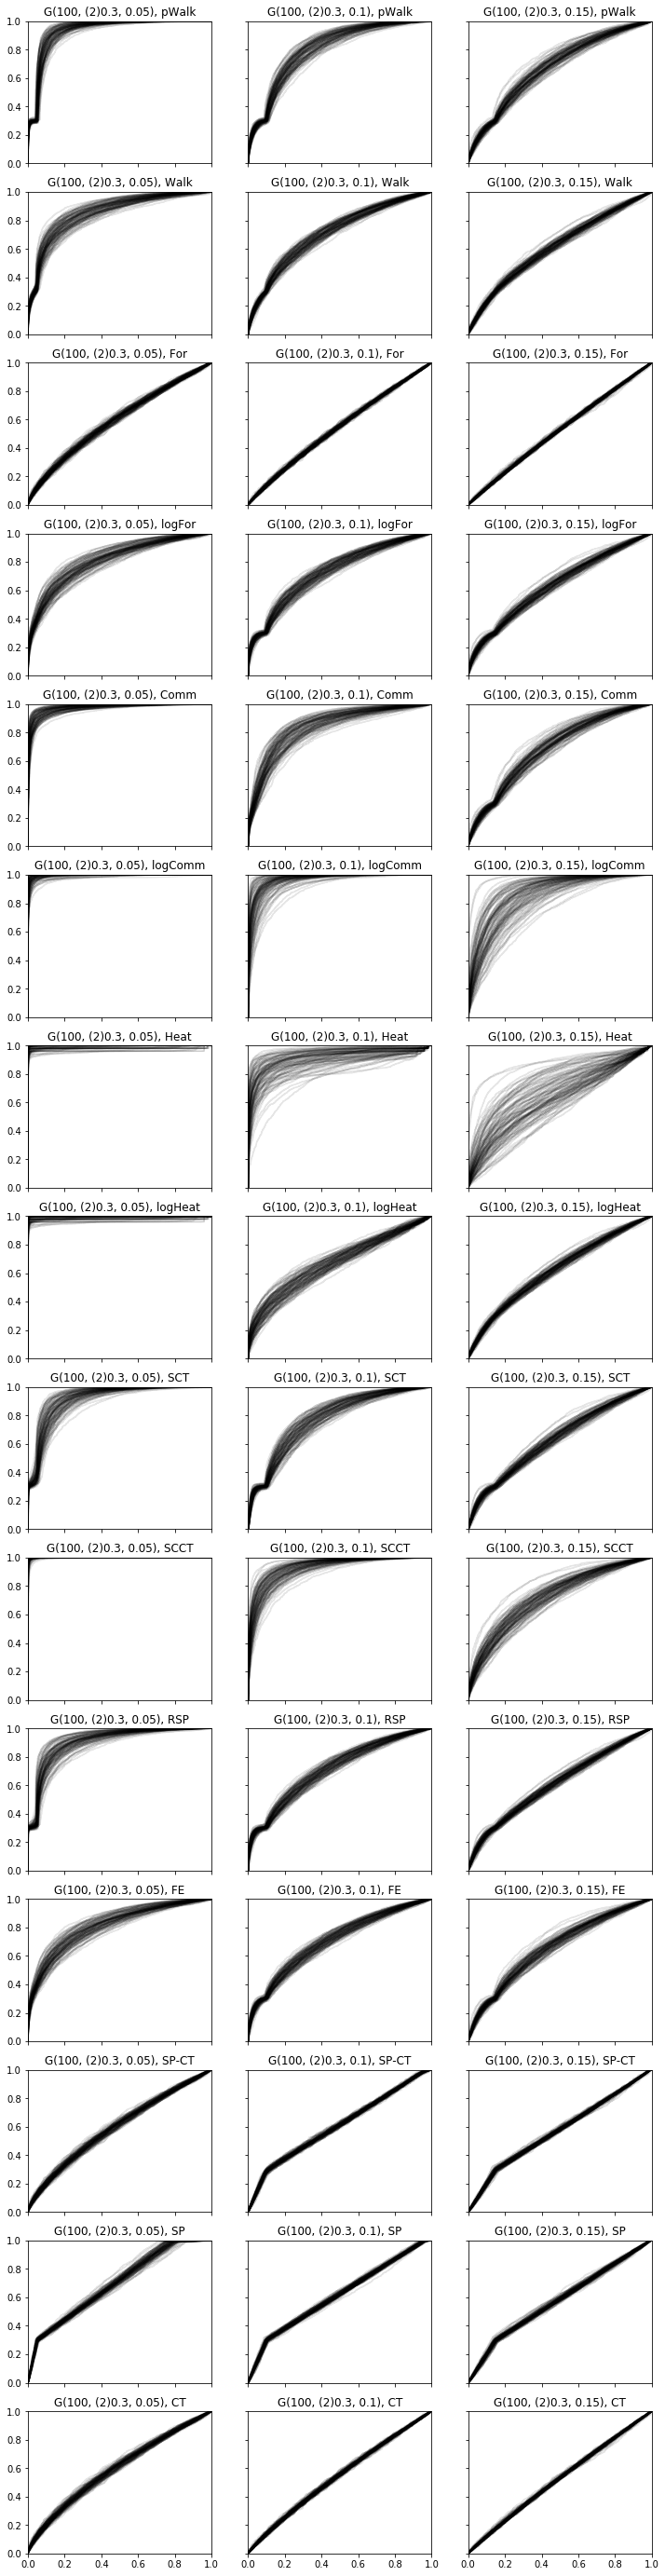

In [8]:
fig, ax = plt.subplots(15, 3, figsize=(12,50), sharex=True, sharey=True)
for column_idx, column in enumerate(results_rc.keys()):
    for measure_name_idx, measure_name in enumerate(measures_right_order):
        measure_name = measure_name[:-2]
        axi = ax[measure_name_idx][column_idx]
        for graph_idx, (tpr, fpr) in enumerate(results_rc[column][measure_name]):
            axi.plot(tpr, fpr, color='black', alpha=0.1)

        axi.set_title("G({}, ({}){}, {}), {}".format(*column, measure_name))
        axi.set_xlim(0,1)
        axi.set_ylim(0,1)
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");

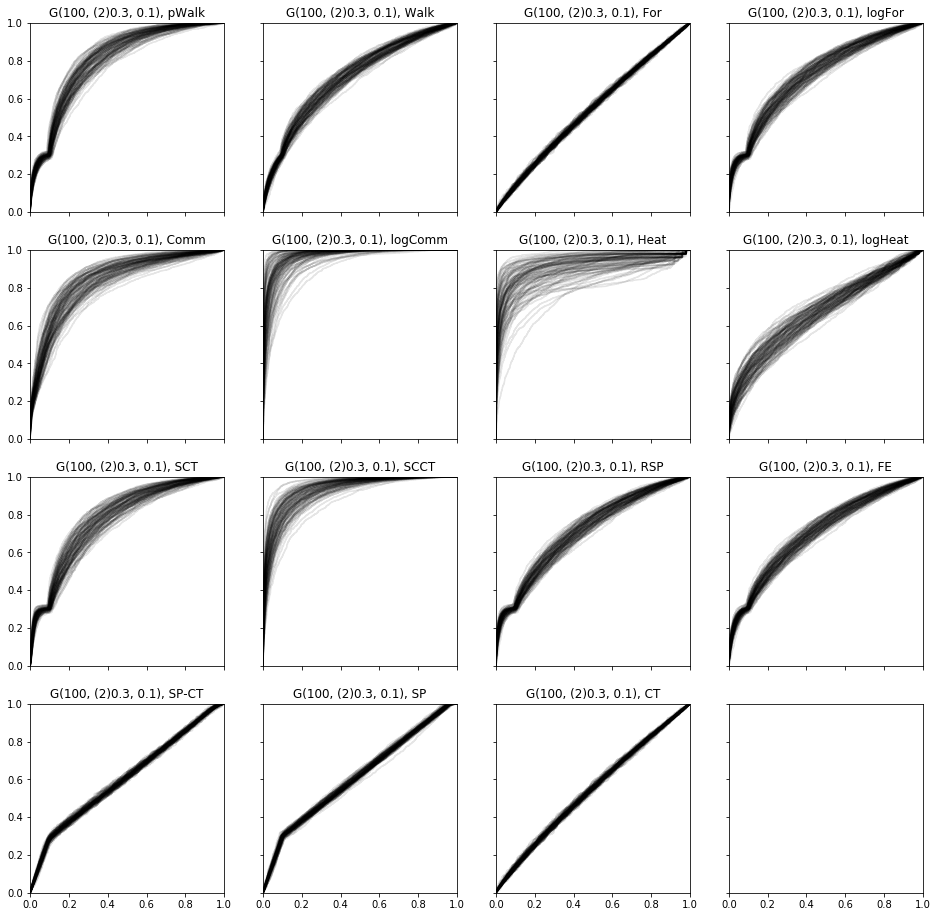

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
column_idx = 1
column = list(results_rc.keys())[1]
for measure_name_idx, measure_name in enumerate(measures_right_order):
    measure_name = measure_name[:-2]
    axi = ax[measure_name_idx // 4][measure_name_idx % 4]
    for graph_idx, (tpr, fpr) in enumerate(results_rc[column][measure_name]):
        axi.plot(tpr, fpr, color='black', alpha=0.1)

    axi.set_title("G({}, ({}){}, {}), {}".format(*column, measure_name))
    axi.set_xlim(0,1)
    axi.set_ylim(0,1)
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");

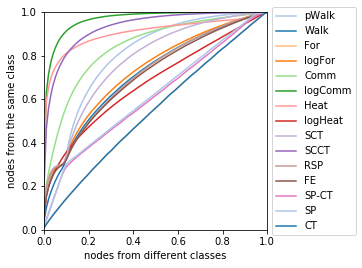

In [10]:
d3c = (x for x in itertools.chain(d3_right_order, d3_right_order))

fig, axi = plt.subplots(1, figsize=(5, 4))
for measure_name_idx, measure_name in enumerate(measures_right_order):
    measure_name = measure_name[:-2]
    tpr_all = defaultdict(list)
    for graph_idx, (tpr, fpr) in enumerate(results_rc[(100, 2, 0.3, 0.10)][measure_name]):
        tprg = defaultdict(list)
        for ti, fi in zip(fpr, tpr):
            tprg[np.floor(fi * 100)].append(ti)
        for bucket, fis in tprg.items():
            tpr_all[bucket].append(np.mean(fis))
    for bucket, fis in tpr_all.items():
        tpr_all[bucket] = np.mean(fis)
    
    axi.plot(np.array(list(tpr_all.keys()), dtype=np.float) / 100, tpr_all.values(), label=measure_name, color=d3c.__next__())

axi.set_xlabel("nodes from different classes")
axi.set_ylabel("nodes from the same class")

box = axi.get_position()
axi.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axi.set_xlim(0,1)
axi.set_ylim(0,1)
axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");

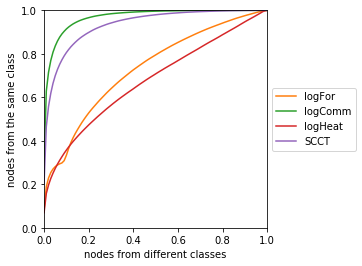

In [11]:
d3c = (x for x in itertools.chain(d3_right_order, d3_right_order))

fig, axi = plt.subplots(1, figsize=(5, 4))
for measure_name_idx, measure_name in enumerate(measures_right_order):
    measure_name = measure_name[:-2]
    tpr_all = defaultdict(list)
    for graph_idx, (tpr, fpr) in enumerate(results_rc[(100, 2, 0.3, 0.10)][measure_name]):
        tprg = defaultdict(list)
        for ti, fi in zip(fpr, tpr):
            tprg[np.floor(fi * 100)].append(ti)
        for bucket, fis in tprg.items():
            tpr_all[bucket].append(np.mean(fis))
    for bucket, fis in tpr_all.items():
        tpr_all[bucket] = np.mean(fis)
    
    color = d3c.__next__()
    
    if measure_name not in ['logComm', 'logFor', 'logHeat', 'SCCT']:
        continue
    
    axi.plot(np.array(list(tpr_all.keys()), dtype=np.float) / 100, tpr_all.values(), label=measure_name, color=color)

axi.set_xlabel("nodes from different classes")
axi.set_ylabel("nodes from the same class")

box = axi.get_position()
axi.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axi.set_xlim(0,1)
axi.set_ylim(0,1)
axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");